In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import StepLR
import torchvision.models as models
import matplotlib.pyplot as plt

## 確認裝置

In [12]:
# 1. 裝置設定
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"使用裝置：{device}")

使用裝置：cuda:0


## 下載資料集

In [13]:
# 訓練集 Data Augmentation
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # 顏色增強
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# 測試集只正規化
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=0, pin_memory=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False, num_workers=0, pin_memory=True)


In [14]:
class CNN2(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        act = nn.ReLU()

        # Block 1
        self.block1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            act,
            nn.MaxPool2d(2, 2)  # 32 -> 16
        )
        # Block 2
        self.block2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            act,
            nn.MaxPool2d(2, 2)  # 16 -> 8
        )
        # Block 3 (增加表達力)
        self.block3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            act,
            nn.MaxPool2d(2, 2)  # 8 -> 4
        )

        # Global Average Pooling
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.block1(x)   # (B,32,16,16)
        x = self.block2(x)   # (B,64,8,8)
        x = self.block3(x)   # (B,128,4,4)
        x = self.gap(x)      # (B,128,1,1)
        x = x.view(x.size(0), -1)  # (B,128)
        x = self.fc1(x)      # (B,num_classes)
        return x


# 建立模型
model2 = CNN2().to(device)
print(model2)

# Loss & Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model2.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=5, gamma=0.5)  # 學習率調度


CNN2(
  (block1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (gap): AdaptiveAvgPool2d(output_size=1)
  (fc1): Linear(in_features=128, out_features=10, bias=True)
)


Epoch 1/20 — Train Loss: 1.5362, Train Acc: 0.4467 — Val Loss: 1.5632, Val Acc: 0.4563
Epoch 2/20 — Train Loss: 1.2526, Train Acc: 0.5529 — Val Loss: 1.1461, Val Acc: 0.5886
Epoch 3/20 — Train Loss: 1.1314, Train Acc: 0.6009 — Val Loss: 1.1196, Val Acc: 0.5965
Epoch 4/20 — Train Loss: 1.0496, Train Acc: 0.6309 — Val Loss: 1.3996, Val Acc: 0.5292
Epoch 5/20 — Train Loss: 0.9852, Train Acc: 0.6562 — Val Loss: 0.9378, Val Acc: 0.6757
Epoch 6/20 — Train Loss: 0.9093, Train Acc: 0.6823 — Val Loss: 0.9106, Val Acc: 0.6781
Epoch 7/20 — Train Loss: 0.8839, Train Acc: 0.6938 — Val Loss: 0.9386, Val Acc: 0.6735
Epoch 8/20 — Train Loss: 0.8557, Train Acc: 0.7048 — Val Loss: 0.8665, Val Acc: 0.6954
Epoch 9/20 — Train Loss: 0.8429, Train Acc: 0.7062 — Val Loss: 1.0636, Val Acc: 0.6381
Epoch 10/20 — Train Loss: 0.8210, Train Acc: 0.7152 — Val Loss: 0.8346, Val Acc: 0.7044
Epoch 11/20 — Train Loss: 0.7862, Train Acc: 0.7316 — Val Loss: 0.7689, Val Acc: 0.7340
Epoch 12/20 — Train Loss: 0.7700, Train A

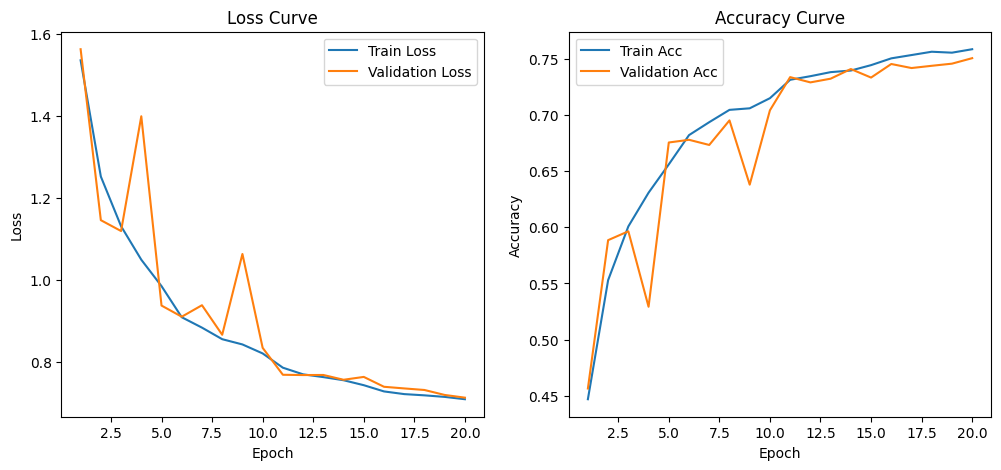

In [15]:
num_epochs = 20  # 加深後模型收斂快，10~15 epoch 就能上 75%

train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []

best_acc, best_state = 0.0, None

for epoch in range(1, num_epochs + 1):
    # ====== 訓練 ======
    model2.train()
    running_loss, correct, total = 0.0, 0, 0
    for imgs, labels in trainloader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model2(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)
        _, preds = outputs.max(1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()

    epoch_loss = running_loss / len(trainloader.dataset)
    epoch_acc = correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    # ====== 驗證 ======
    model2.eval()
    val_running_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for imgs, labels in testloader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model2(imgs)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item() * imgs.size(0)
            _, preds = outputs.max(1)
            val_total += labels.size(0)
            val_correct += (preds == labels).sum().item()

    val_loss = val_running_loss / len(testloader.dataset)
    val_acc = val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch}/{num_epochs} — "
          f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f} — "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    if val_acc > best_acc:
        best_acc = val_acc
        best_state = {k: v.cpu() for k, v in model2.state_dict().items()}

    scheduler.step()

# 還原最佳模型
if best_state is not None:
    model2.load_state_dict(best_state)
    print(f"Loaded best checkpoint, Val Acc={best_acc:.4f}")

# ====== 繪製曲線 ======
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses)+1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses)+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Loss Curve'); plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_accuracies)+1), train_accuracies, label='Train Acc')
plt.plot(range(1, len(val_accuracies)+1), val_accuracies, label='Validation Acc')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Accuracy Curve'); plt.legend()

plt.show()
